In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("ETTh1.csv")
df["date"] = pd.to_datetime(df["date"])
df.set_index("date", inplace=True)

target = "OT"

In [3]:
n = len(df)
train_size = int(n * 0.7)
val_size = int(n * 0.2)

train_df = df.iloc[:train_size]
val_df = df.iloc[train_size:train_size + val_size]
test_df = df.iloc[train_size + val_size:]

In [4]:
def create_features(data, target, lags=[1, 24, 48], windows=[24, 48]):
    df_feat = data.copy()

    for lag in lags:
        df_feat[f"{target}_lag_{lag}"] = df_feat[target].shift(lag)

    for window in windows:
        df_feat[f"{target}_roll_mean_{window}"] = (
            df_feat[target].shift(1).rolling(window).mean()
        )
        df_feat[f"{target}_roll_std_{window}"] = (
            df_feat[target].shift(1).rolling(window).std()
        )

    df_feat = df_feat.dropna()
    return df_feat

In [5]:
train_feat = create_features(train_df, target)
val_feat = create_features(val_df, target)
test_feat = create_features(test_df, target)

X_train = train_feat.drop(columns=[target])
y_train = train_feat[target]

X_val = val_feat.drop(columns=[target])
y_val = val_feat[target]

X_test = test_feat.drop(columns=[target])
y_test = test_feat[target]

In [6]:
model = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)]
)

[0]	validation_0-rmse:11.37833
[1]	validation_0-rmse:10.82584
[2]	validation_0-rmse:10.35592
[3]	validation_0-rmse:9.90938
[4]	validation_0-rmse:9.51892
[5]	validation_0-rmse:9.06010
[6]	validation_0-rmse:8.62332
[7]	validation_0-rmse:8.20743
[8]	validation_0-rmse:7.82805
[9]	validation_0-rmse:7.44986
[10]	validation_0-rmse:7.09096
[11]	validation_0-rmse:6.75071
[12]	validation_0-rmse:6.42619
[13]	validation_0-rmse:6.13232
[14]	validation_0-rmse:5.85579
[15]	validation_0-rmse:5.60802
[16]	validation_0-rmse:5.35067
[17]	validation_0-rmse:5.10862
[18]	validation_0-rmse:4.87911
[19]	validation_0-rmse:4.70925
[20]	validation_0-rmse:4.49454
[21]	validation_0-rmse:4.30618
[22]	validation_0-rmse:4.15319
[23]	validation_0-rmse:3.96516
[24]	validation_0-rmse:3.79663
[25]	validation_0-rmse:3.63611
[26]	validation_0-rmse:3.48374
[27]	validation_0-rmse:3.33583
[28]	validation_0-rmse:3.21372
[29]	validation_0-rmse:3.10110
[30]	validation_0-rmse:2.98371
[31]	validation_0-rmse:2.87788
[32]	validation

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [7]:
def evaluate(y_true, y_pred, label=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{label} MAE: {mae:.3f}")
    print(f"{label} RMSE: {rmse:.3f}")
    return mae, rmse

In [8]:
y_pred_test = model.predict(X_test)
xgb_mae, xgb_rmse = evaluate(y_test, y_pred_test, "XGBoost")

XGBoost MAE: 0.448
XGBoost RMSE: 0.648


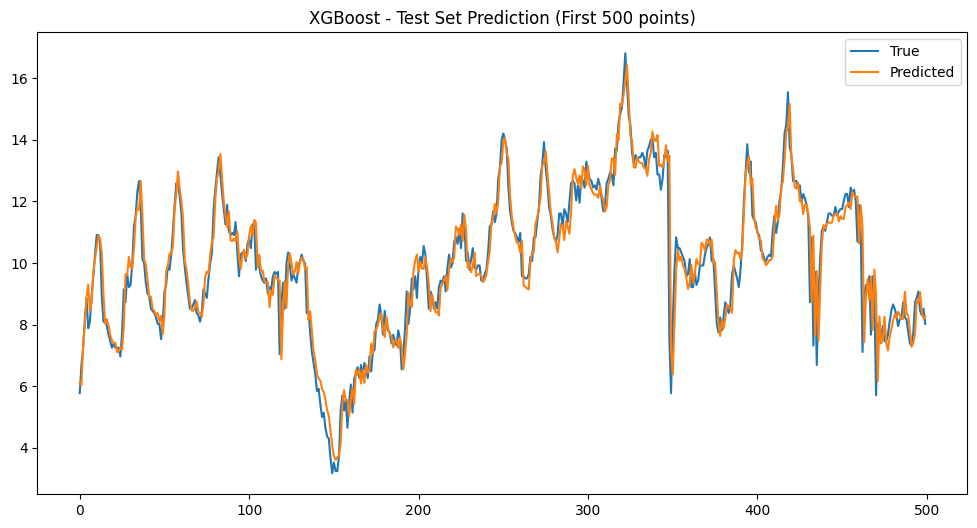

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:500], label="True")
plt.plot(y_pred_test[:500], label="Predicted")
plt.title("XGBoost - Test Set Prediction (First 500 points)")
plt.legend()
plt.show()

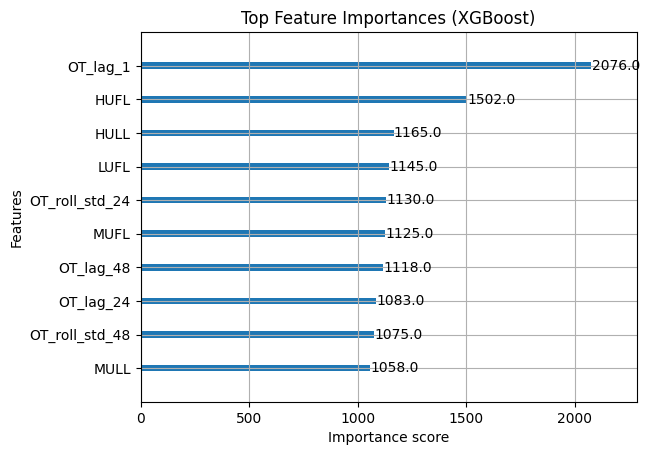

In [10]:
xgb.plot_importance(model, max_num_features=10)
plt.title("Top Feature Importances (XGBoost)")
plt.show()